In [110]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import load_data

outcomes = [load_data.outcome_cases, load_data.outcome_deaths]
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = df_county.sort_values(load_data.outcome_deaths, ascending=False)
df = df_hospital.merge(df_county, how='left', on='countyFIPS')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# note this many hospitals couldn't be matched to a county - we don't know how to include them!
print('# unmatched hospitals:', df['countyFIPS'].isna().sum())
print('# matched hospitals:', (~df['countyFIPS'].isna()).sum())
print('# academic matched hospitals:', (~df['countyFIPS'].isna() & df['IsAcademicHospital']).sum())
df = df[df['IsAcademicHospital']]
df = df.sort_values(load_data.outcome_deaths, ascending=False)

# unmatched hospitals: 129
# matched hospitals: 1215
# academic matched hospitals: 1215


# look at important hospitals

In [105]:
hospital_keys = ['Facility Name_x', 'County Name_x', 'City_x',
                 'ICU Beds', 'Total Beds', 'Total Employees', 
                 'Hospital Type', 'Mortality national comparison',  
                 'Website', 'Urban or Rural Designation', 'Phone Number'] + ['countyFIPS']
d = df[outcomes + hospital_keys]
d[outcomes] = d[outcomes].fillna(0)
d.head(30)

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,#Cases_3/23/2020,#Deaths_3/23/2020,Facility Name_x,County Name_x,City_x,ICU Beds,Total Beds,Total Employees,Hospital Type,Mortality national comparison,Website,Urban or Rural Designation,Phone Number,countyFIPS
3838,12305.0,125.0,NYC Health + Hospitals Harlem,"New York County, NY",New York,17.0,282.0,2126.0,Acute Care Hospitals,Same as the national average,http://www.nychealthandhospitals.org/harlem/ht...,Urban,(212) 939-1000,36061.0
3935,12305.0,125.0,Kirby Forensic Psychiatric Center,"New York County, NY",Wards Island,0.0,193.0,608.0,Psychiatric,Not Available,https://www.omh.ny.gov/omhweb/facilities/krpc/,Urban,(212) 427-9003,36061.0
3908,12305.0,125.0,NYC Health + Hospitals Carter,"New York County, NY",New York,0.0,365.0,697.0,NaN,NaN,http://www.nychealthandhospitals.org/carter/ht...,Urban,NaN,36061.0
3811,12305.0,125.0,NYC Health + Hospitals Metropolitan,"New York County, NY",New York,24.0,338.0,1596.0,Acute Care Hospitals,Not Available,http://www.nyc.gov/html/hhc/mhc/html/home/home...,Urban,(212) 423-6262,36061.0
3815,12305.0,125.0,NYC Health + Hospitals Bellevue,"New York County, NY",New York,45.0,912.0,4179.0,Acute Care Hospitals,Same as the national average,http://www.nychealthandhospitals.org/bellevue/...,Urban,(212) 562-4141,36061.0
3720,12305.0,125.0,The Mount Sinai Hospital,"New York County, NY",New York,75.0,1161.0,11256.0,Acute Care Hospitals,Above the national average,http://www.nyc.gov/html/hhc/mhc/html/home/home...,Urban,(212) 241-7981,36061.0
3820,12305.0,125.0,NYU Langone Tisch Hospital,"New York County, NY",New York,228.0,1629.0,16151.0,Acute Care Hospitals,Above the national average,http://nyulangone.org/locations/tisch-hospital,Urban,(212) 263-7300,36061.0
3934,12305.0,125.0,Manhattan Psychiatric Center,"New York County, NY",New York,0.0,209.0,735.0,Psychiatric,Not Available,https://www.omh.ny.gov/omhweb/facilities/krpc/,Urban,(212) 369-0500,36061.0
3794,12305.0,125.0,Mount Sinai Beth Israel Medical Center,"New York County, NY",New York,28.0,554.0,4672.0,Acute Care Hospitals,Above the national average,http://www.bethisraelny.org/,Rural,(212) 420-2000,36061.0
3767,12305.0,125.0,Lenox Hill Hospital,"New York County, NY",New York,24.0,449.0,5287.0,Acute Care Hospitals,Above the national average,NOT AVAILABLE,Rural,(212) 439-2345,36061.0


# useful county-level plots

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


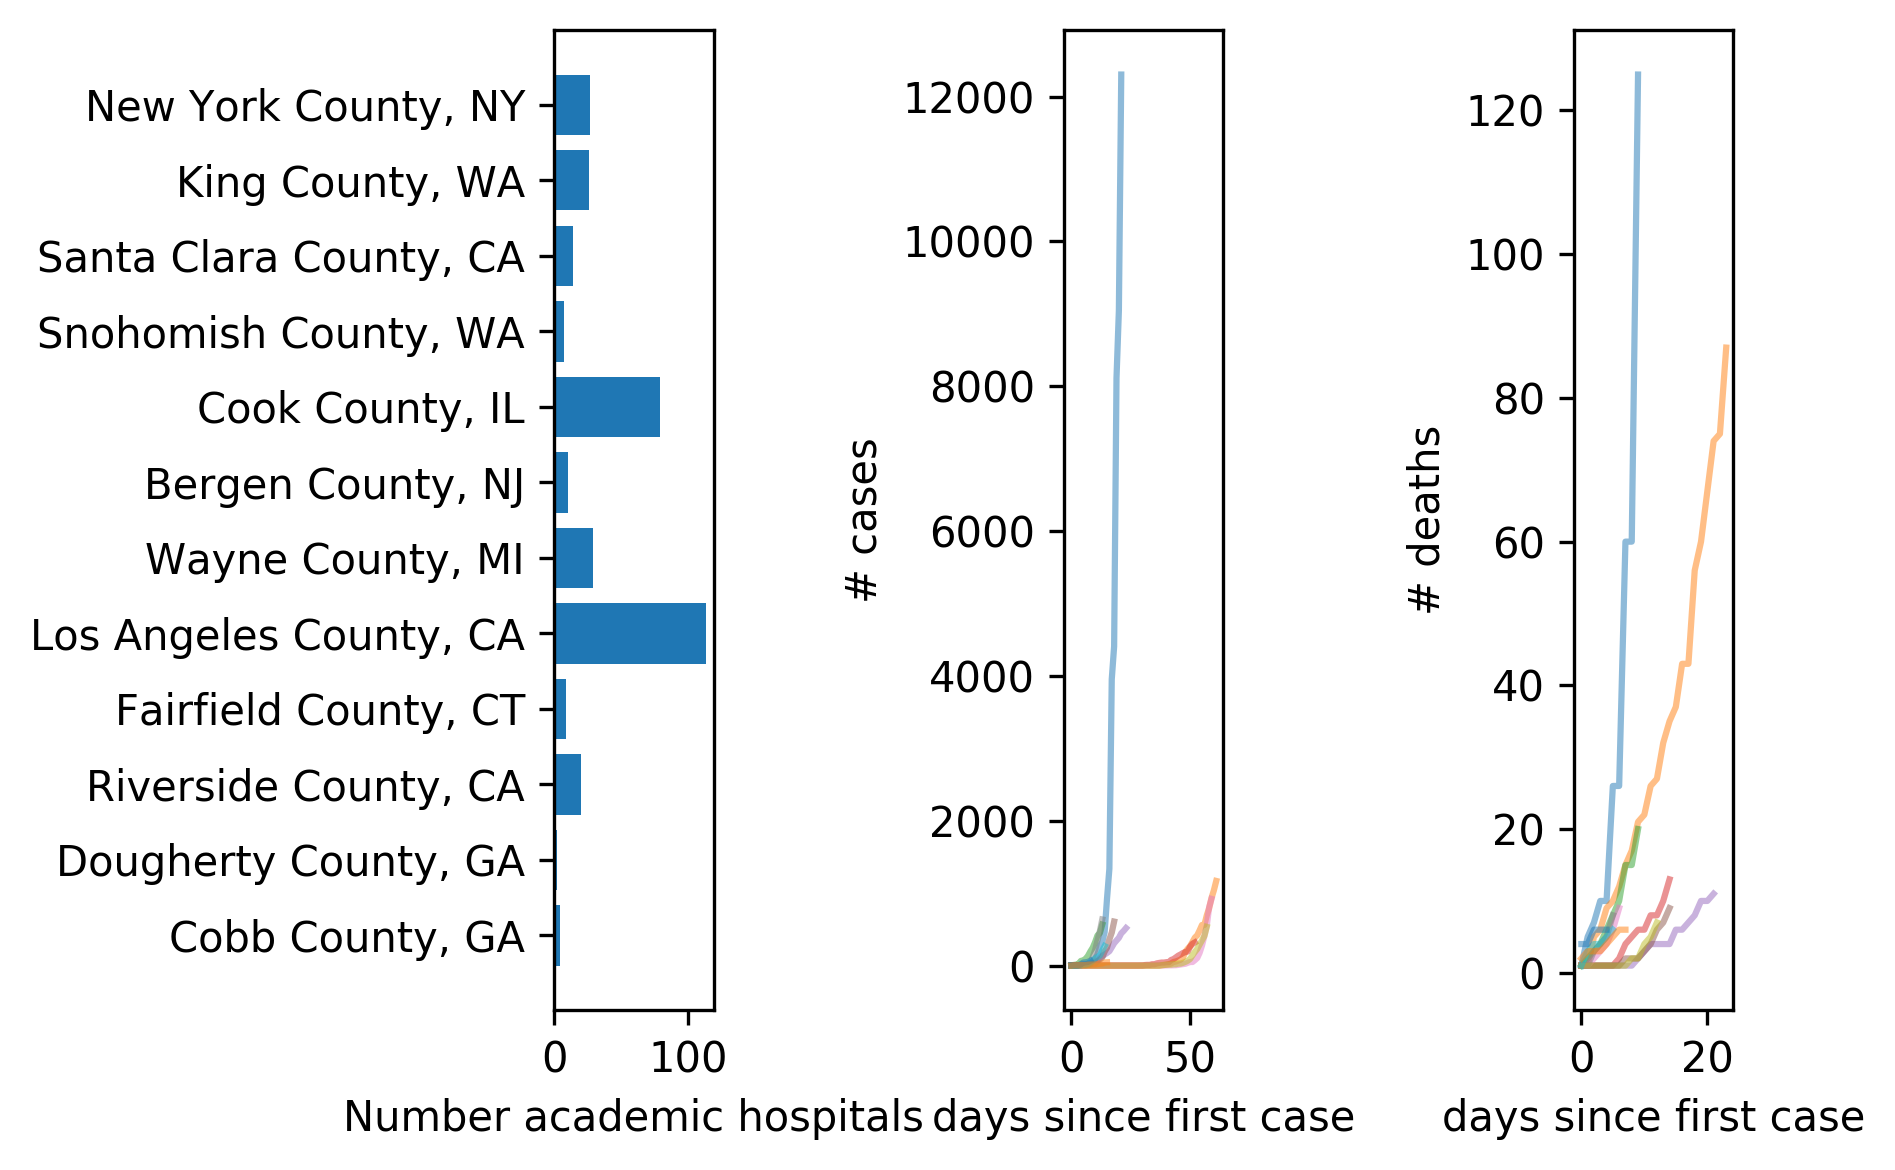

In [113]:
R, C = 1, 3
NUM_COUNTIES = 12
plt.figure(dpi=300)
plt.subplot(R, C, 1)
c = 'County Name_x'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
d = df[outcomes + hospital_keys]
d = d.sort_values(load_data.outcome_deaths, ascending=False)

for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals')


r = df_county
for i in range(NUM_COUNTIES):
    row = r.iloc[i]
    deaths = [x for x in row['deaths'] if x > 0]
    cases = [x for x in row['cases'] if x > 0]
    plt.subplot(R, C, 2)
    plt.plot(cases, alpha=0.5)
    plt.ylabel('# cases')
    plt.xlabel('days since first case')
    
    plt.subplot(R, C, 3)
    plt.plot(deaths, alpha=0.5)
    plt.ylabel('# deaths')
    plt.xlabel('days since first case')
plt.tight_layout()
plt.show()